In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from scipy import stats

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [2]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "futures_dataset_monthly"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    "naive",
    "mvo",
    "bl",
    "linear-ridge",
]

In [3]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] #+ pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [4]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI              0.032678 -0.047984  0.000752 -0.025343  0.063781 -0.045892   
W875RX1         -0.112550 -0.068211 -0.038119  0.032999  0.006149  0.006541   
DPCERA3M086SBEA -0.146550  0.027131 -0.060616  0.042417 -0.018647 -0.143320   
CMRMTSPLx       -0.135673 -0.008126 -0.053135  0.014012  0.024570 -0.093309   
RETAILx         -0.127633  0.065554 -0.019088  0.035344  0.000766 -0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx        -0.037855  0.012142 -0.030014 -0.014400 -0.012411 -0.098975   
DTCOLNVHFNM     -0.002451  0.009939  0.011267 -0.016205 -0.015283 -0.058104   
DTCTHFNM        -0.006255  0.013653  0.012419 -0.018355 -0.013001 -0.032122   
INVEST          -0.015517  0.016652 -0.007961  0.011221 -0.015233  0.019285   
VIXCLSx          0.052323  0.001555  0.009238  0.039914 -0.001340 -0.121704   

                      PC6       PC7       PC8      

In [5]:
# get regimes
#memory_dir_name = "kmeans_elbow"
memory_dir_name = 'kmeans'
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [6]:
pd.DataFrame(memory_data.columns)

0
0    PC0
1    PC1
2    PC2
3    PC3
4    PC4
..   ...
56  PC56
57  PC57
58  PC58
59  PC59
60  PC60

[61 rows x 1 columns]

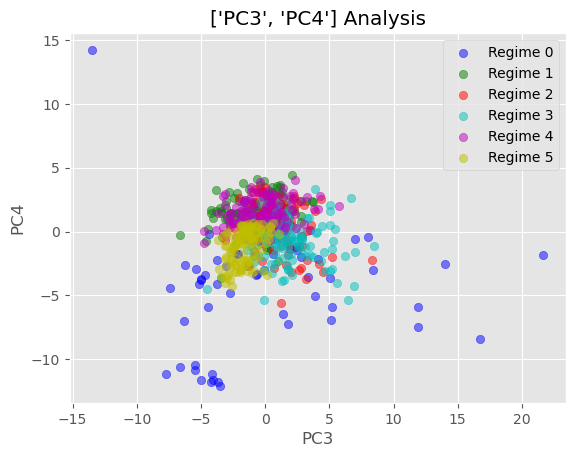

In [7]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_vars = ['PC3', 'PC4']

plt.clf()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(6):
    plt.scatter(memory_data[macro_vars[0]][:-1][regimes['cluster_step697'] == i], memory_data[macro_vars[1]][:-1][regimes['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
plt.title(f"{macro_vars} Analysis")
plt.xlabel(macro_vars[0])
plt.ylabel(macro_vars[1])
plt.legend()
plt.show()

In [8]:
# etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
# macro_var = 'PC0'

# for etf in etfs:
#     plt.clf()
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']
#     for i in range(6):
#         plt.scatter(memory_data[-275:][macro_var][regimes[-275:]['cluster_step697'] == i],
#                     returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
#     plt.title(f"{etf} / {macro_var} Analysis")
#     plt.xlabel(macro_var)
#     plt.ylabel(etf + " Returns")
#     plt.legend()
#     plt.show()

In [9]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
style_map = {}
for method in portfolio_methods:
    print(method)
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        style_map[method + dir.split('/')[-1][7:-4]] = f"{cur_color}{cur_line_type}"
        print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # intersect column names
        common_cols = forecasts.columns.intersection(returns.columns)

        # match columns
        forecasts = forecasts[common_cols].copy()
        returns = returns[common_cols].copy()

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

naive
naive results_lo_4_rand.pkl
naive results_los_4.pkl
naive results_los_2.pkl
naive results_los_2_rand.pkl
naive results_los_3.pkl
naive results_lns_4.pkl
naive results_lns_2.pkl
naive results_los_4_rand.pkl
naive results_lns_3_rand.pkl
naive results_lns_4_rand.pkl
naive results_los_3_rand.pkl
naive results_lns_2_rand.pkl
naive results_mx_3.pkl
naive results_mx_4.pkl
naive results_mx_4_rand.pkl
naive results_lo_2.pkl
naive results_mx_3_rand.pkl
naive results_mx_2_rand.pkl
naive results_lo_2_rand.pkl
naive results_mx_2.pkl
naive results_lo_3.pkl
naive results_lo_4.pkl
naive results_lo_3_rand.pkl
naive results_lns_3.pkl
mvo
mvo results_lns_4.pkl
mvo results_lns_2.pkl
mvo results_lo_2.pkl
mvo results_lo_3.pkl
mvo results_lo_4.pkl
mvo results_lns_3.pkl
bl
bl results_lo_4_rand.pkl
bl results_lns_4.pkl
bl results_lns_2.pkl
bl results_lns_3_rand.pkl
bl results_lns_4_rand.pkl
bl results_lns_2_rand.pkl
bl results_lo_2.pkl
bl results_lo_2_rand.pkl
bl results_lo_3.pkl
bl results_lo_4.pkl
bl r

In [10]:
%config InlineBackend.figure_format = 'retina'
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
# spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
# concat_list = [equal_weight_cumm_returns, spy_cumm_returns]
concat_list = [equal_weight_cumm_returns]

model_list = all_portfolio_returns_df["models"].unique()
model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'naive_lns_2_rand',
    'naive_mx_2_rand',
    'naive_los_2_rand',
    'naive_lo_2_rand',
    'naive_lns_3_rand',
    'naive_mx_3_rand',
    'naive_los_3_rand',
    'naive_lo_3_rand',
    'naive_lns_4_rand',
    'naive_mx_4_rand',
    'naive_los_4_rand',
    'naive_lo_4_rand',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',

    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',

    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',

    'linear-ridge_lns_2_rand',
    'linear-ridge_mx_2_rand',
    'linear-ridge_los_2_rand',
    'linear-ridge_lo_2_rand',
    'linear-ridge_lns_3_rand',
    'linear-ridge_mx_3_rand',
    'linear-ridge_los_3_rand',
    'linear-ridge_lo_3_rand',
    'linear-ridge_lns_4_rand',
    'linear-ridge_mx_4_rand',
    'linear-ridge_los_4_rand',
    'linear-ridge_lo_4_rand',
]
print(style_map)
styles = ['m', 'c'] + [style_map[model] for model in model_list]
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    # ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # # Place the legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

{'naive_lo_4_rand': 'r-', 'naive_los_4': 'r--', 'naive_los_2': 'r-.', 'naive_los_2_rand': 'r:', 'naive_los_3': 'r-', 'naive_lns_4': 'r--', 'naive_lns_2': 'r-.', 'naive_los_4_rand': 'r:', 'naive_lns_3_rand': 'r-', 'naive_lns_4_rand': 'r--', 'naive_los_3_rand': 'r-.', 'naive_lns_2_rand': 'r:', 'naive_mx_3': 'r-', 'naive_mx_4': 'r--', 'naive_mx_4_rand': 'r-.', 'naive_lo_2': 'r:', 'naive_mx_3_rand': 'r-', 'naive_mx_2_rand': 'r--', 'naive_lo_2_rand': 'r-.', 'naive_mx_2': 'r:', 'naive_lo_3': 'r-', 'naive_lo_4': 'r--', 'naive_lo_3_rand': 'r-.', 'naive_lns_3': 'r:', 'mvo_lns_4': 'b-', 'mvo_lns_2': 'b--', 'mvo_lo_2': 'b-.', 'mvo_lo_3': 'b:', 'mvo_lo_4': 'b-', 'mvo_lns_3': 'b--', 'bl_lo_4_rand': 'g-', 'bl_lns_4': 'g--', 'bl_lns_2': 'g-.', 'bl_lns_3_rand': 'g:', 'bl_lns_4_rand': 'g-', 'bl_lns_2_rand': 'g--', 'bl_lo_2': 'g-.', 'bl_lo_2_rand': 'g:', 'bl_lo_3': 'g-', 'bl_lo_4': 'g--', 'bl_lo_3_rand': 'g-.', 'bl_lns_3': 'g:', 'linear-ridge_lo_4_rand': 'y-', 'linear-ridge_los_4': 'y--', 'linear-ridge_

In [11]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

In [12]:
all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_lo_4_rand         2.182139  12.955117  0.583488  1.141891  -2.870538   
naive_los_4             0.921201  19.419955  0.164322  0.208186  -6.788780   
naive_los_2             2.504325  19.803903  0.438057  1.117604  -4.332053   
naive_los_2_rand        1.810147  16.307108  0.384528  0.683248  -3.208423   
naive_los_3             4.015619  40.311993  0.345071  0.447842 -11.561251   
...                          ...        ...       ...       ...        ...   
linear-ridge_mx_2       2.045127  13.047019  0.543000  0.959820  -1.895729   
linear-ridge_lo_3       3.048471  14.033258  0.752513  1.325004  -1.786446   
linear-ridge_lo_4       3.942750  18.038850  0.757148  1.704890  -1.857178   
linear-ridge_lo_3_rand  1.917284  12.112913  0.548313  0.908448  -2.345378   
linear-ridge_lns_3      3.147495  11.584872  0.941162  1.965926  -1.198408   

                            MaxDD  % Positive Ret.  
naive_lo_4_rand        -10.229287         0.568720  
naive_los_4            -24.719678         0.545024  
naive_los_2            -16.457658         0.554502  
naive_los_2_rand       -14.121792         0.545024  
naive_los_3            -30.966377         0.592417  
...                           ...              ...  
linear-ridge_mx_2       -6.536754         0.549763  
linear-ridge_lo_3       -6.796080         0.578199  
linear-ridge_lo_4       -6.816904         0.578199  
linear-ridge_lo_3_rand  -8.007932         0.528571  
linear-ridge_lns_3      -9.382033         0.597156  

[66 rows x 7 columns]

In [13]:
all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_lo_4_rand         2.182139  12.955117  0.583488  1.141891  -2.870538   
naive_los_4             0.921201  19.419955  0.164322  0.208186  -6.788780   
naive_los_2             2.504325  19.803903  0.438057  1.117604  -4.332053   
naive_los_2_rand        1.810147  16.307108  0.384528  0.683248  -3.208423   
naive_los_3             4.015619  40.311993  0.345071  0.447842 -11.561251   
...                          ...        ...       ...       ...        ...   
linear-ridge_mx_2       2.045127  13.047019  0.543000  0.959820  -1.895729   
linear-ridge_lo_3       3.048471  14.033258  0.752513  1.325004  -1.786446   
linear-ridge_lo_4       3.942750  18.038850  0.757148  1.704890  -1.857178   
linear-ridge_lo_3_rand  1.917284  12.112913  0.548313  0.908448  -2.345378   
linear-ridge_lns_3      3.147495  11.584872  0.941162  1.965926  -1.198408   

                            MaxDD  % Positive Ret.  
naive_lo_4_rand        -10.229287         0.568720  
naive_los_4            -24.719678         0.545024  
naive_los_2            -16.457658         0.554502  
naive_los_2_rand       -14.121792         0.545024  
naive_los_3            -30.966377         0.592417  
...                           ...              ...  
linear-ridge_mx_2       -6.536754         0.549763  
linear-ridge_lo_3       -6.796080         0.578199  
linear-ridge_lo_4       -6.816904         0.578199  
linear-ridge_lo_3_rand  -8.007932         0.528571  
linear-ridge_lns_3      -9.382033         0.597156  

[66 rows x 7 columns]

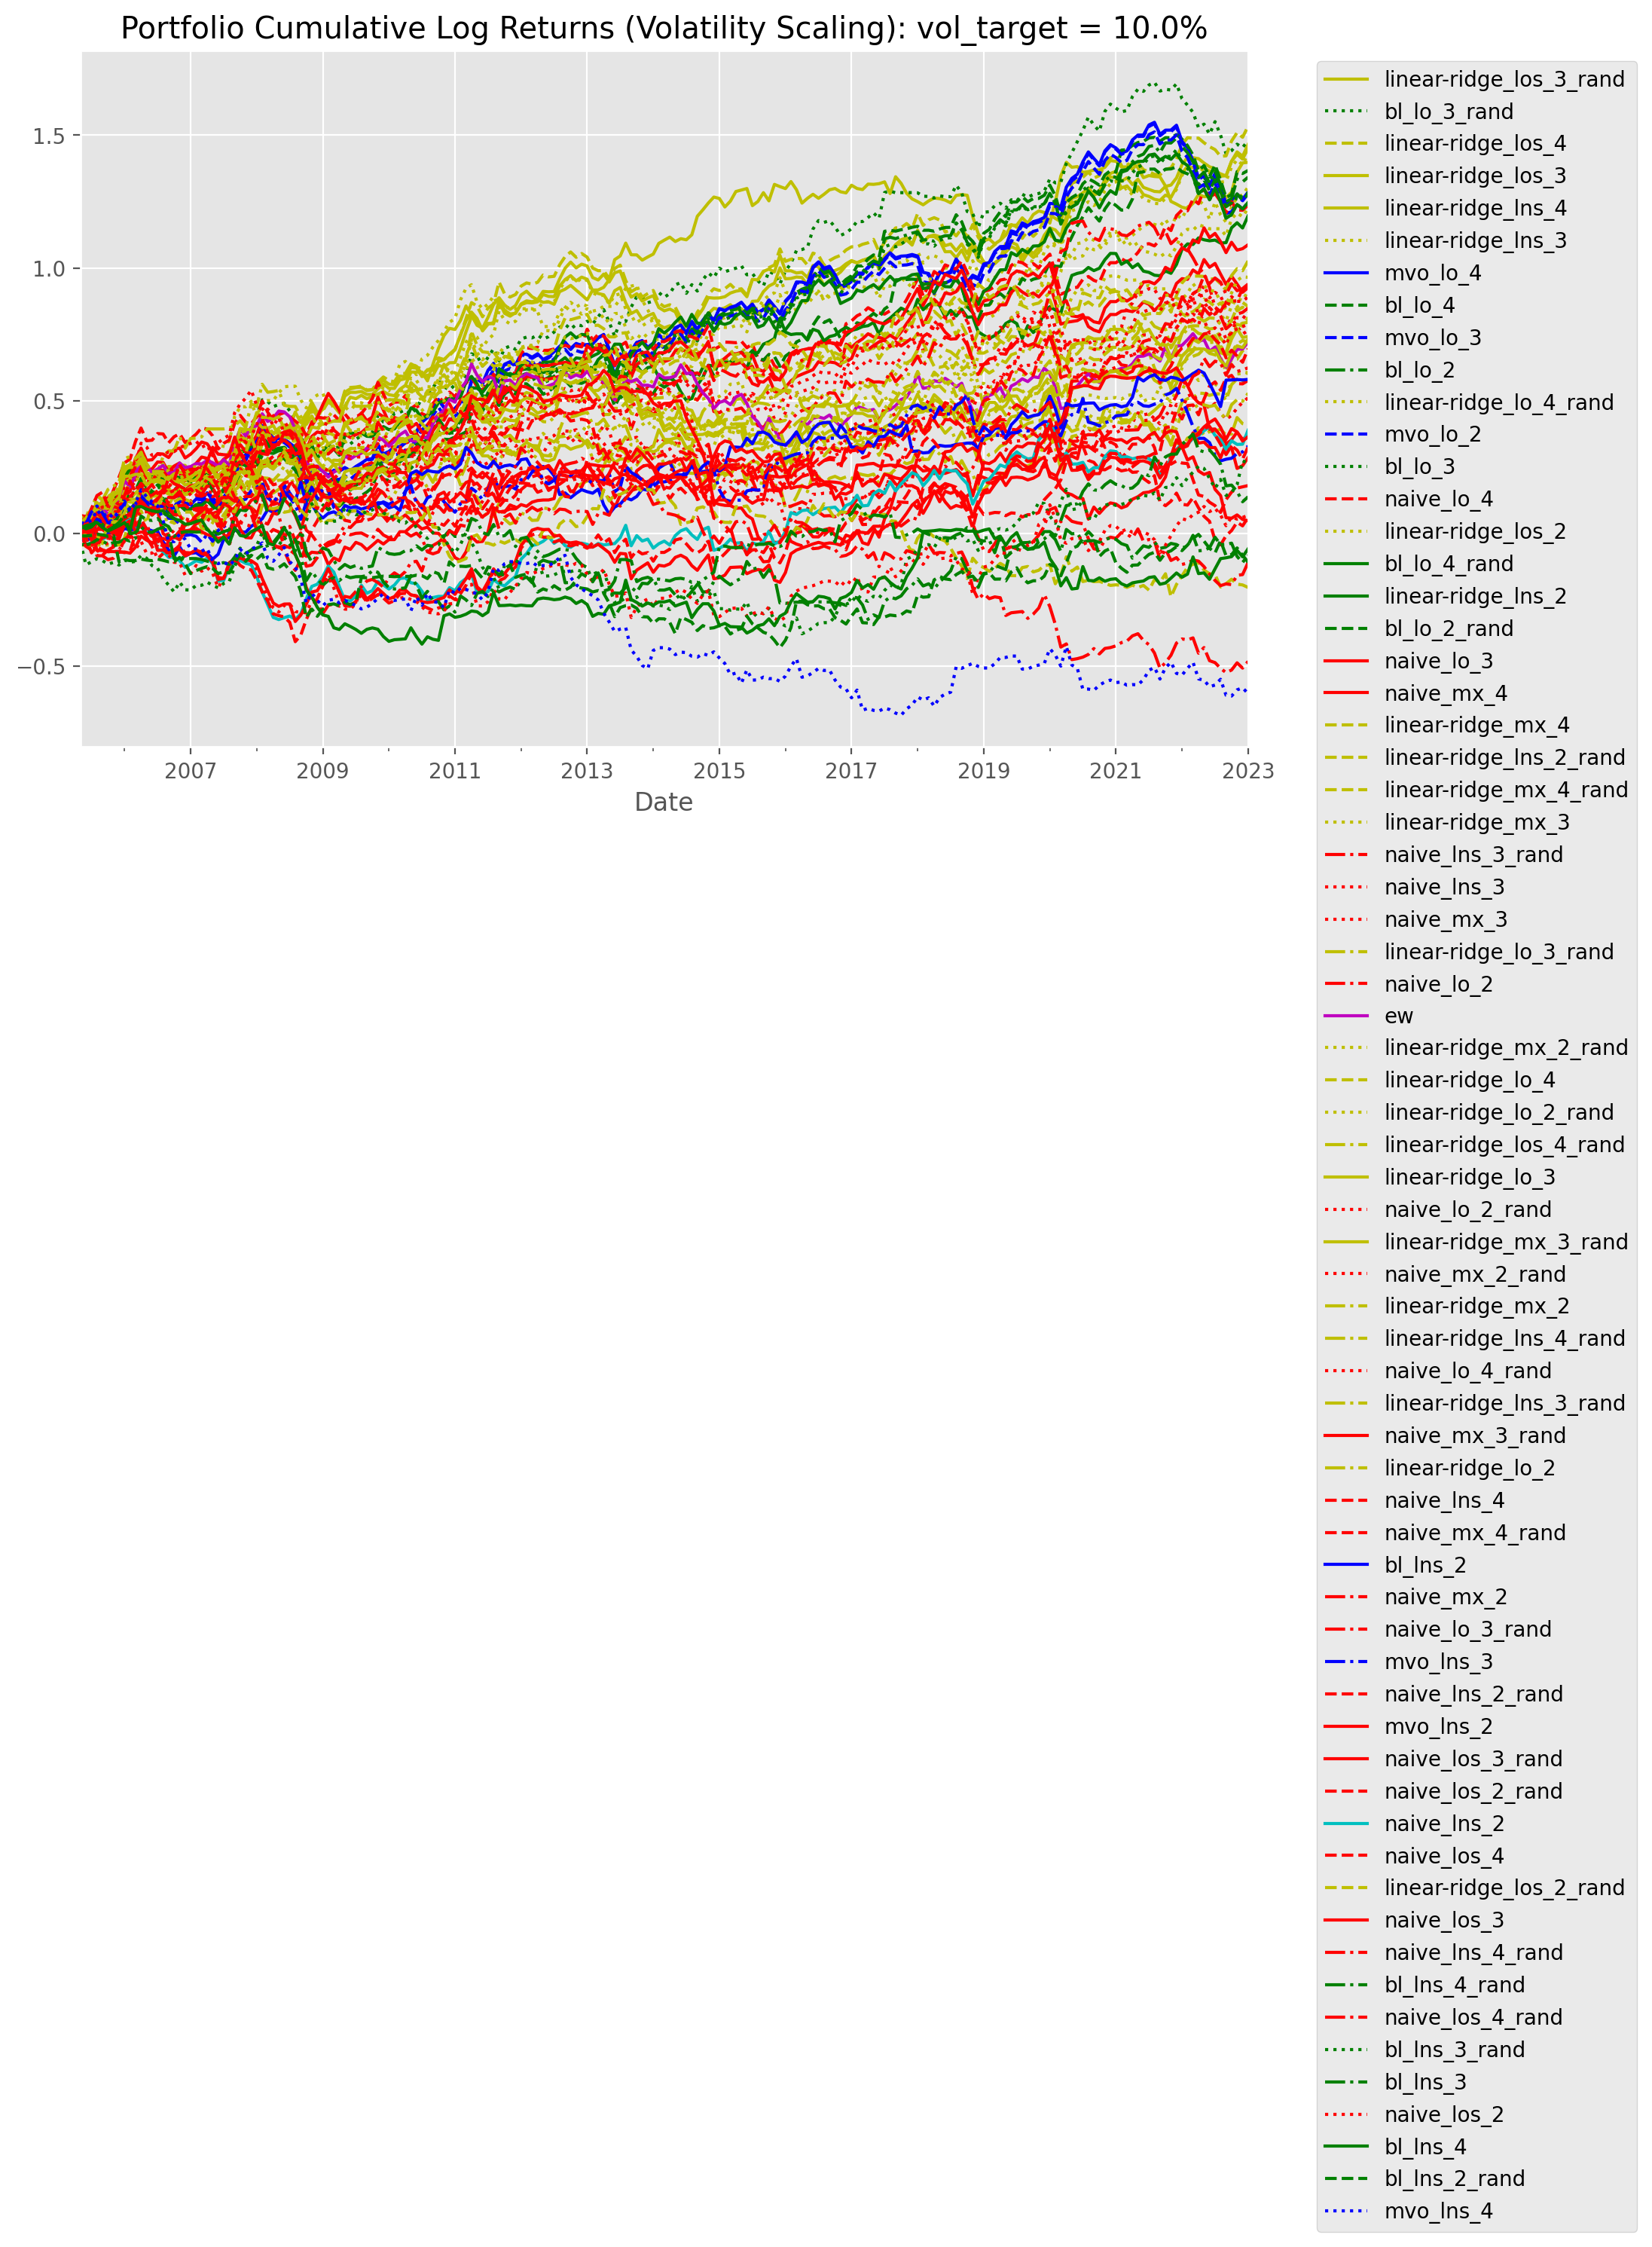

In [14]:
returns = pd.concat(concat_list, axis=1)
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index
order_style = list(cum_voladj_returns.mean(axis=0).argsort())
ax = cum_voladj_returns[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

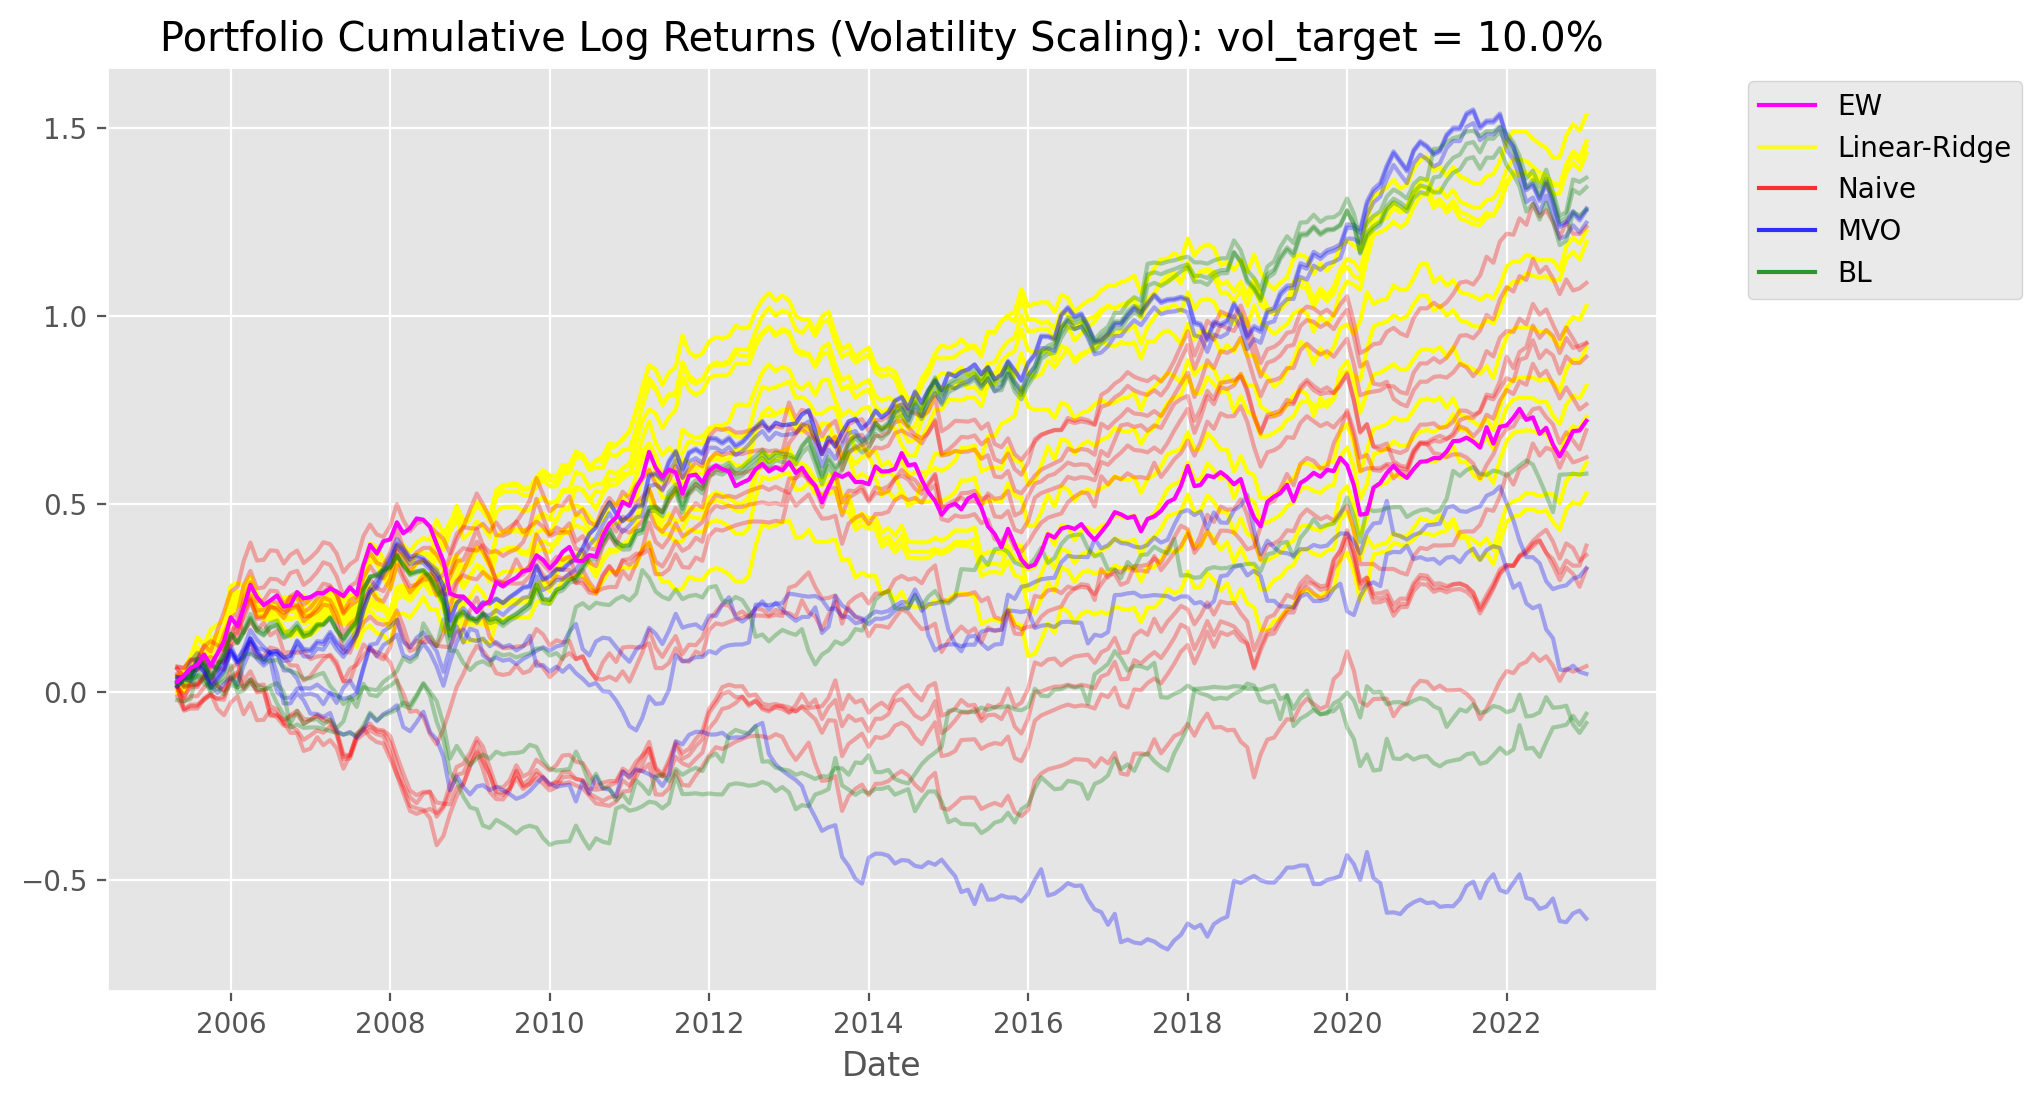

In [16]:
# Group models
linear_ridge_models = [m for m in returns.columns if (m.startswith('linear-ridge')) and (not m.endswith('rand'))]
naive_models = [m for m in returns.columns if (m.startswith('naive')) and (not m.endswith('rand'))]
mvo_models = [m for m in returns.columns if (m.startswith('mvo')) and (not m.endswith('rand'))]
bl_models = [m for m in returns.columns if (m.startswith('bl')) and (not m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
for model in linear_ridge_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='yellow', alpha=1)
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)
for model in bl_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='green', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='magenta', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='cyan', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='yellow', label='Linear-Ridge', alpha=0.8)
plt.plot([], [], color='red', label='Naive', alpha=0.8)
plt.plot([], [], color='blue', label='MVO', alpha=0.8)
plt.plot([], [], color='green', label='BL', alpha=0.8)

plt.title(f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_all_cum_ret_by_groups.png"), bbox_inches='tight', dpi=300)

plt.show()

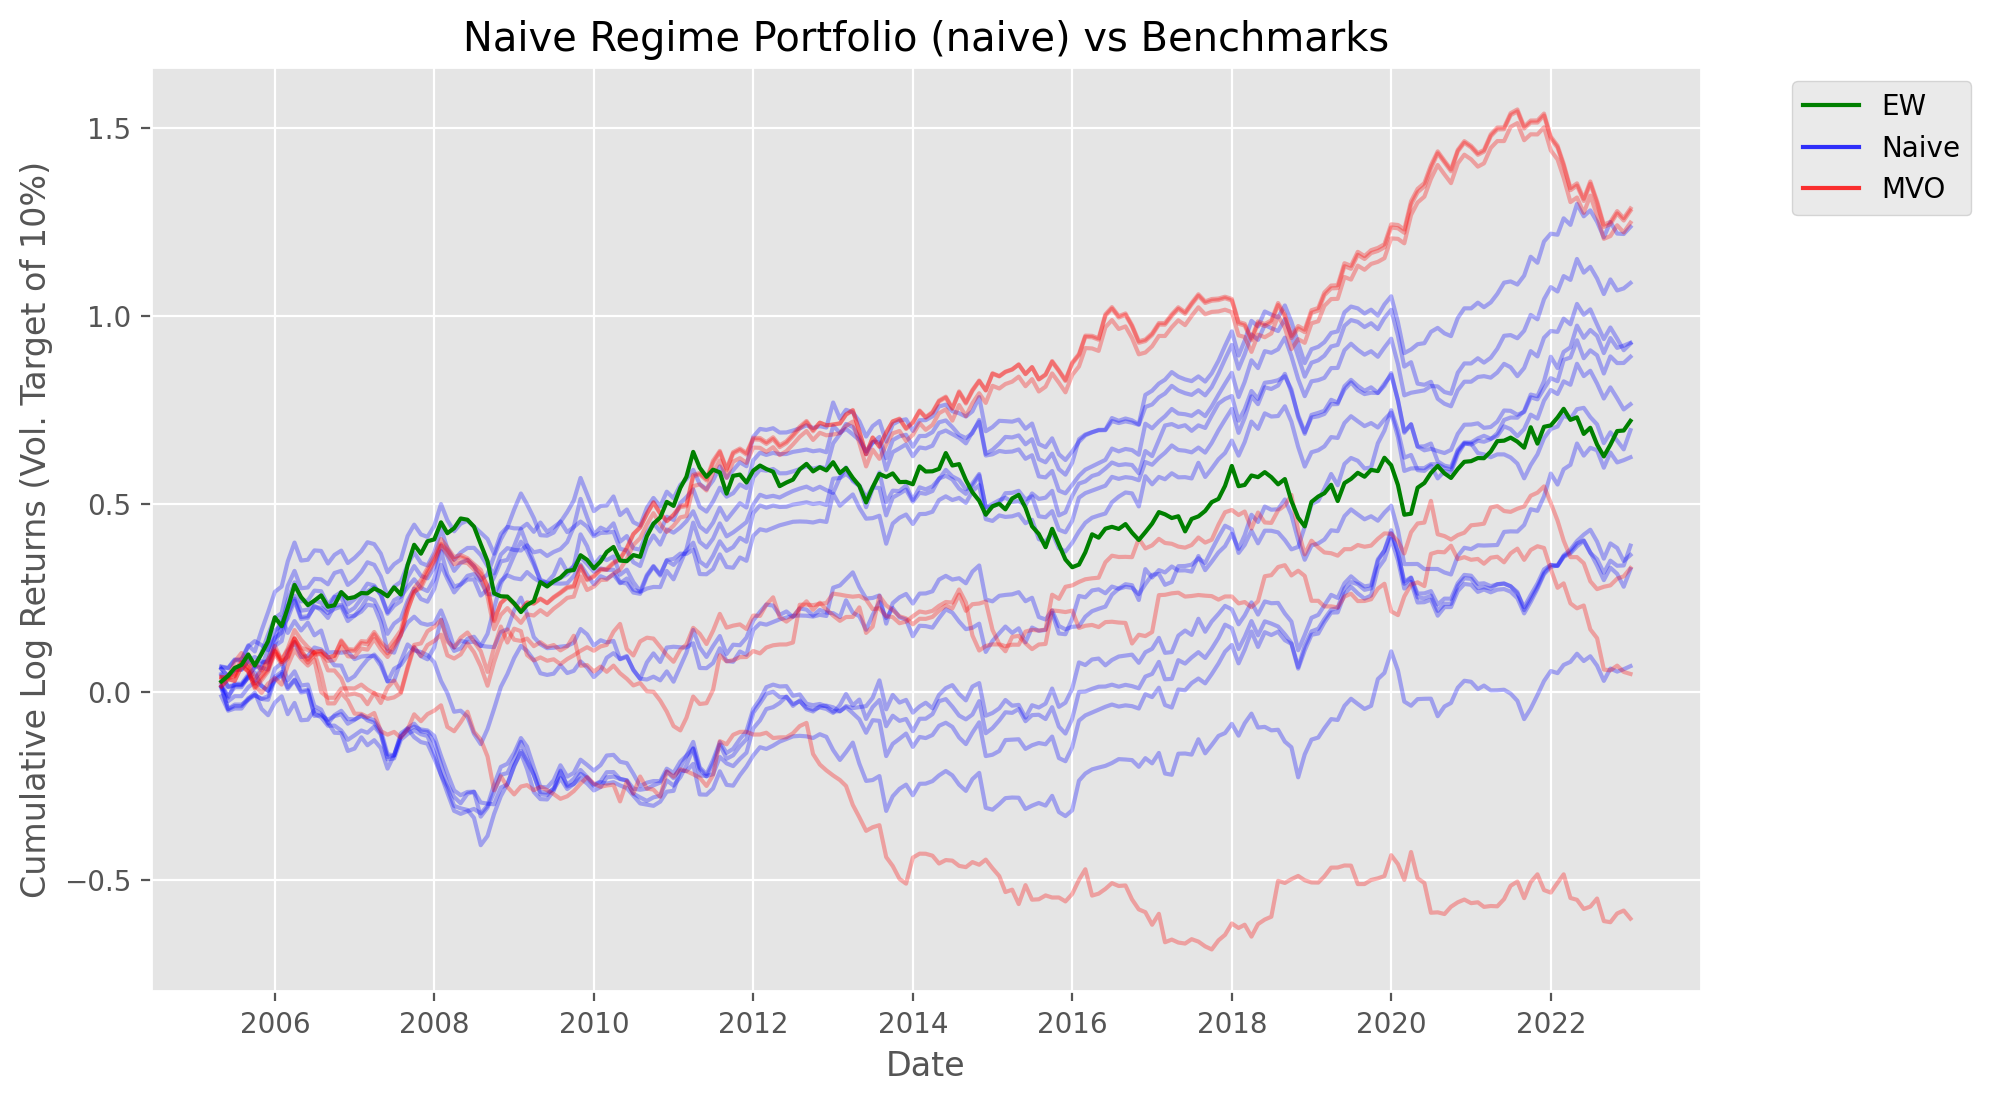

In [17]:
super_benchmarks = ['ew']
selected_model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('naive')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='blue', label='Naive', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Naive Regime Portfolio (naive) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_naive_vs_benchmarks_cumret.png"), bbox_inches='tight', dpi=300)

plt.show()

In [18]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  % Positive Ret.
naive_lns_2  1.539  18.389   0.290    0.344  -6.895 -22.132            0.592
naive_mx_2   2.713  11.679   0.805    1.502  -1.256  -6.323            0.597
naive_los_2  2.504  19.804   0.438    1.118  -4.332 -16.458            0.555
naive_lo_2   3.649  12.298   1.028    2.232  -0.880  -4.791            0.602
naive_lns_3  3.608  14.056   0.889    1.720  -1.281  -5.319            0.597
naive_mx_3   4.304  30.631   0.487    1.763  -1.967  -7.735            0.583
naive_los_3  4.016  40.312   0.345    0.448 -11.561 -30.966            0.592
naive_lo_3   4.613  32.496   0.492    0.913  -2.496 -16.283            0.592
naive_mx_4   3.165  14.549   0.754    1.499  -1.514  -6.867            0.583
naive_lns_4  1.603  14.358   0.387    0.666  -2.823 -16.067            0.531
naive_los_4  0.921  19.420   0.164    0.208  -6.789 -24.720            0.545
naive_lo_4   2.887  29.237   0.342    0.274  -6.614 -27.965            0.597
mvo_lns_2   -0.466  13.436  -0.120   -0.142  -5.228 -15.119            0.536
mvo_lo_2     4.512  14.803   1.056    2.504  -1.268  -8.332            0.611
mvo_lns_3    1.498  15.435   0.336    0.440  -3.129 -11.944            0.555
mvo_lo_3     4.742  15.645   1.050    2.477  -1.323  -9.254            0.616
mvo_lns_4   -1.686  16.349  -0.357   -0.424 -20.907 -36.351            0.488
mvo_lo_4     4.402  14.613   1.044    2.178  -1.333  -9.590            0.621

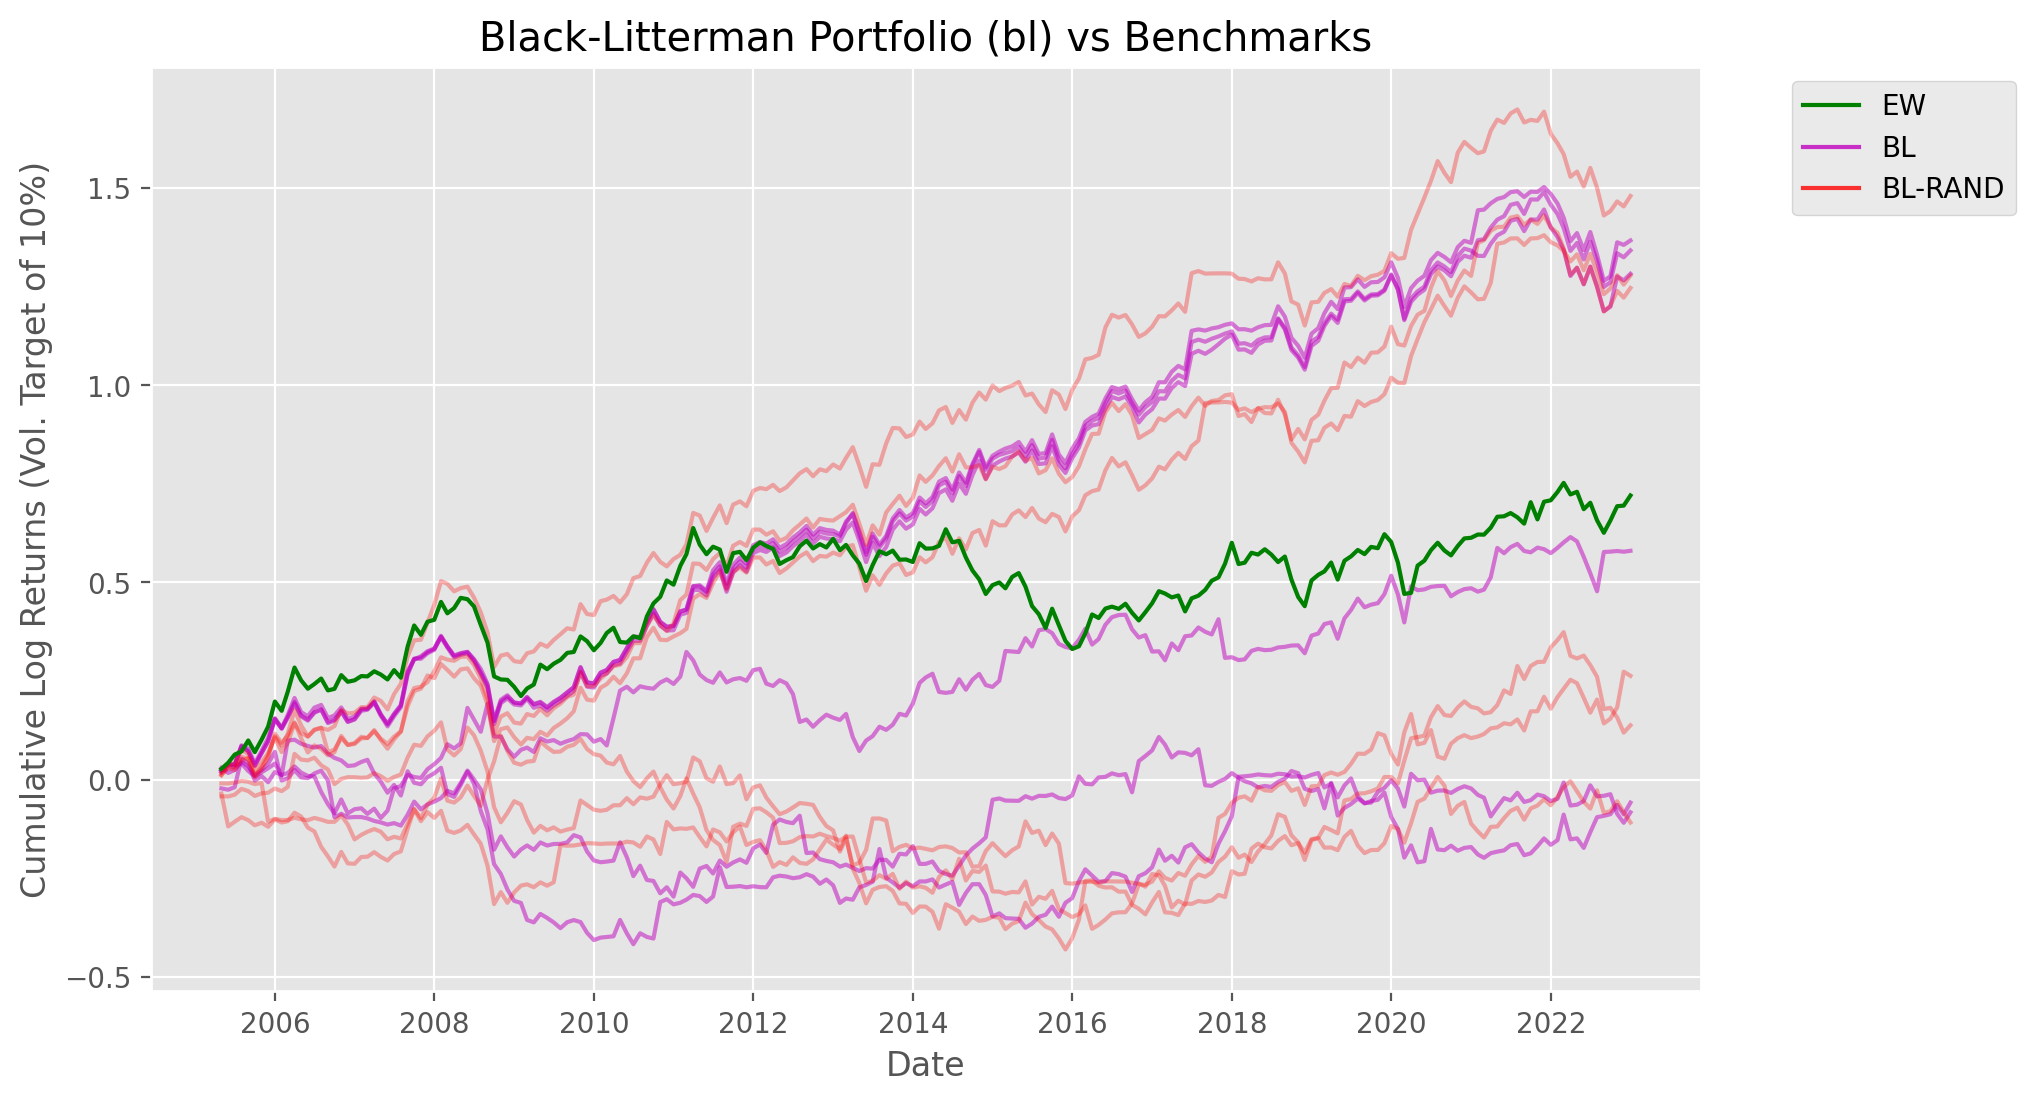

In [19]:
super_benchmarks = ['ew']
selected_model_list = [
    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',
   #  'bl_lns_5',
   #  'bl_lo_5',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',
   #  'bl_lns_5_rand',
   #  'bl_lo_5_rand',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if (m.startswith('bl')) and (not m.endswith('rand'))]
mvo_models = [m for m in selected_model_list if (m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='m', alpha=0.5)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='m', label='BL', alpha=0.8)
plt.plot([], [], color='red', label='BL-RAND', alpha=0.8)

plt.title(f"Black-Litterman Portfolio (bl) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_bl_vs_benchmarks_cumret.png"), bbox_inches='tight', dpi=300)

plt.show()

In [22]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  % Positive Ret.
bl_lns_2       5.087  56.425   0.312    1.539  -1.779 -11.379            0.569
bl_lo_2        4.998  15.723   1.101    2.366  -1.255  -8.661            0.645
bl_lns_3       0.713  13.072   0.189    0.312  -3.570 -10.323            0.517
bl_lo_3        5.075  17.323   1.015    2.482  -1.247  -8.747            0.635
bl_lns_4       0.545  15.991   0.118    0.204 -12.953 -23.437            0.531
bl_lo_4        4.589  14.846   1.071    1.936  -1.318  -9.751            0.649
bl_lns_2_rand  0.212  11.575   0.063    0.105  -5.280 -15.889            0.507
bl_lo_2_rand   4.064  14.607   0.964    2.346  -1.224  -7.627            0.616
bl_lns_3_rand  1.299  13.805   0.326    0.505  -6.810 -19.683            0.545
bl_lo_3_rand   8.920  65.166   0.474    4.769  -1.296  -7.617            0.611
bl_lns_4_rand  1.059  12.453   0.295    0.518  -4.079 -12.840            0.545
bl_lo_4_rand   4.316  13.126   1.139    2.366  -1.080  -7.370            0.640

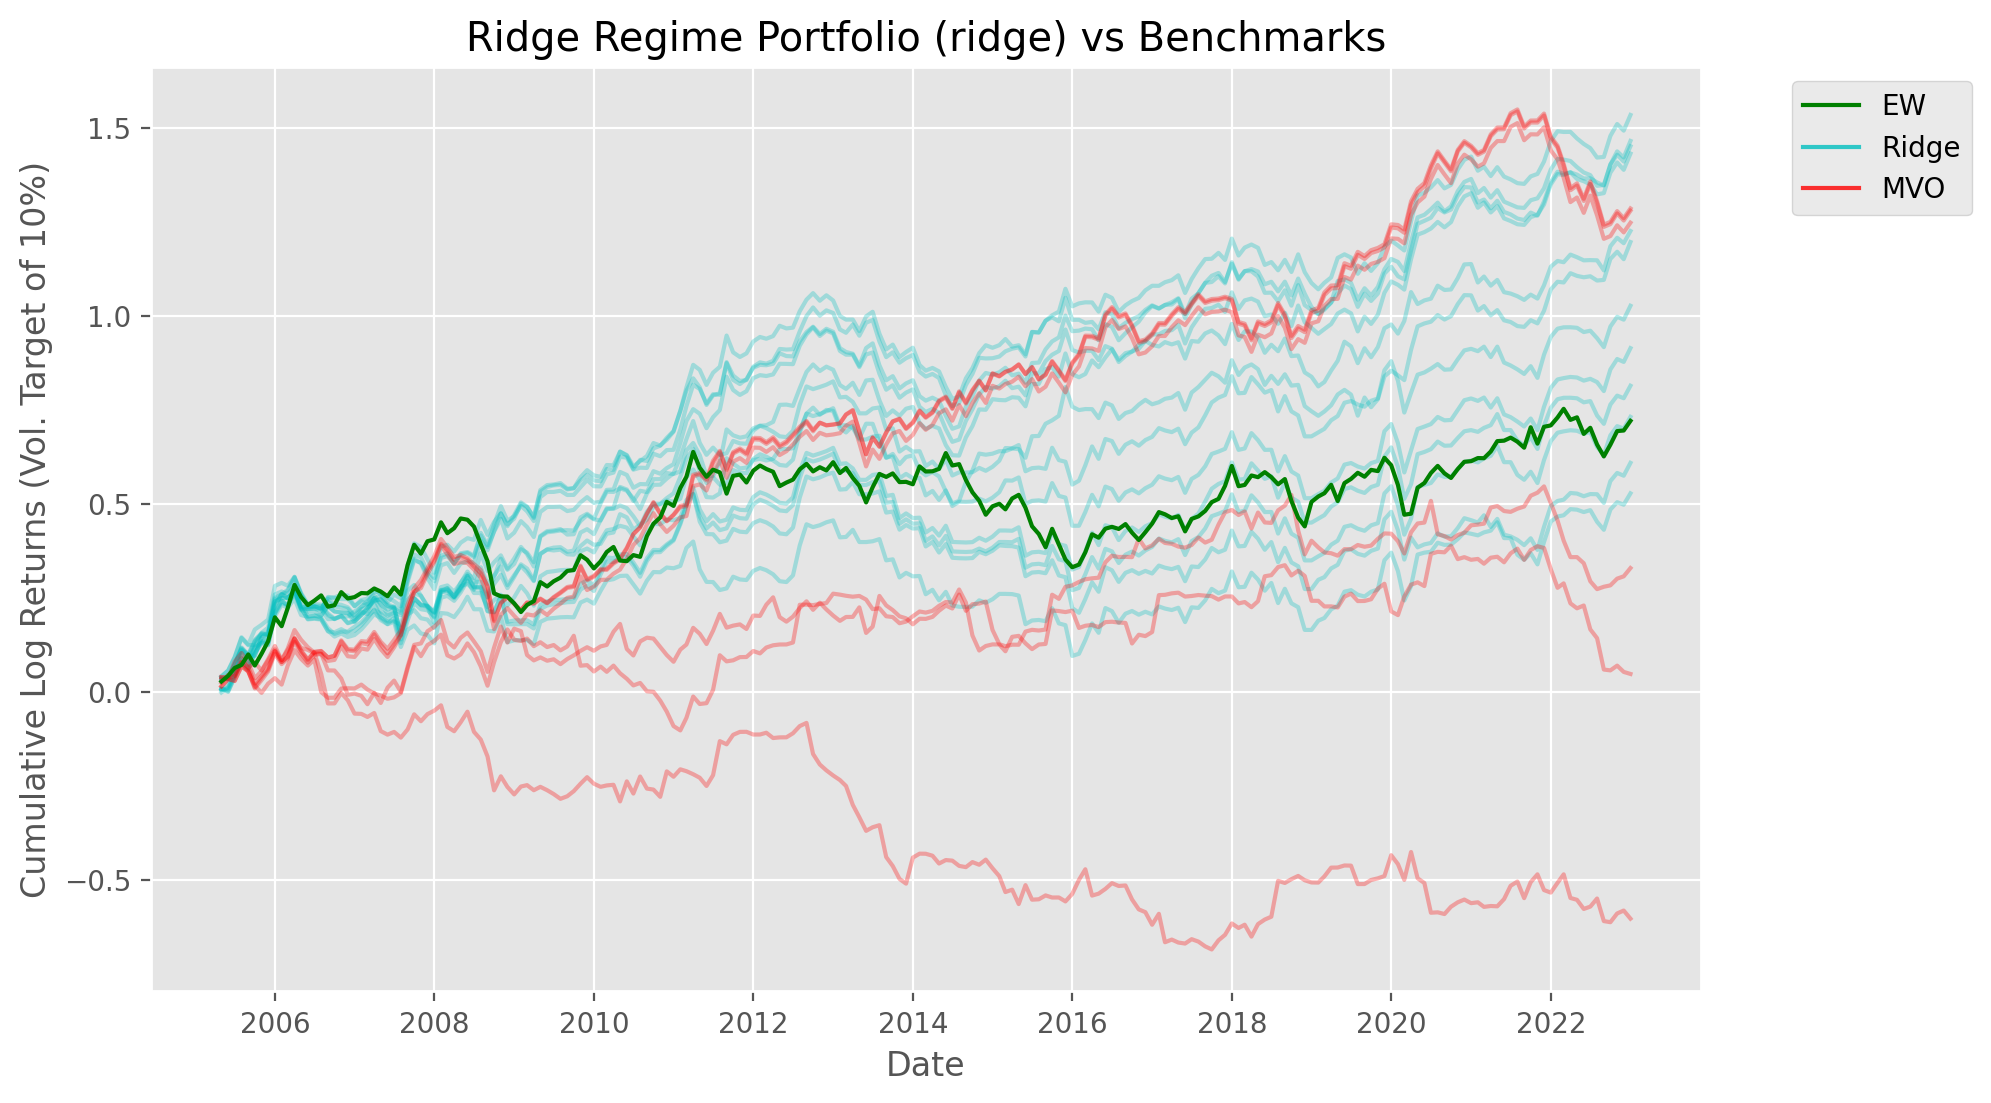

In [20]:
super_benchmarks = ['ew']
selected_model_list = [
    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',
   # 'linear-ridge_mx_5',
   #  'linear-ridge_los_5',
   #  'linear-ridge_lo_5',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('linear-ridge')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

# Define colors for each group
colors = {
   'linear-ridge': 'red',
   'mvo': 'blue', 
   'ew': 'green',
   'spy': 'black'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='c', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='c', label='Ridge', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Ridge Regime Portfolio (ridge) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_ridge_vs_benchmarks_cumret.png"), bbox_inches='tight', dpi=300)

plt.show()

In [25]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  \
linear-ridge_lns_2  2.722  12.503   0.754    1.634  -1.541  -8.501   
linear-ridge_mx_2   2.045  13.047   0.543    0.960  -1.896  -6.537   
linear-ridge_los_2  1.158  22.234   0.180    0.139  -5.646 -22.418   
linear-ridge_lo_2   2.288  13.216   0.600    1.122  -1.838  -6.162   
linear-ridge_lns_3  3.147  11.585   0.941    1.966  -1.198  -9.382   
linear-ridge_mx_3   2.387  13.932   0.593    0.940  -1.835  -6.760   
linear-ridge_los_3  3.861  13.207   1.013    2.472  -1.105  -7.710   
linear-ridge_lo_3   3.048  14.033   0.753    1.325  -1.786  -6.796   
linear-ridge_lns_4  3.380  16.462   0.711    1.491  -1.883  -9.352   
linear-ridge_mx_4   3.280  18.106   0.628    1.197  -1.948  -7.754   
linear-ridge_los_4  3.529  15.172   0.806    1.914  -1.420  -9.047   
linear-ridge_lo_4   3.943  18.039   0.757    1.705  -1.857  -6.817   
mvo_lns_2          -0.466  13.436  -0.120   -0.142  -5.228 -15.119   
mvo_lo_2            4.512  14.803   1.056    2.504  -1.268  -8.332   
mvo_lns_3           1.498  15.435   0.336    0.440  -3.129 -11.944   
mvo_lo_3            4.742  15.645   1.050    2.477  -1.323  -9.254   
mvo_lns_4          -1.686  16.349  -0.357   -0.424 -20.907 -36.351   
mvo_lo_4            4.402  14.613   1.044    2.178  -1.333  -9.590   

                    % Positive Ret.  
linear-ridge_lns_2            0.573  
linear-ridge_mx_2             0.550  
linear-ridge_los_2            0.569  
linear-ridge_lo_2             0.555  
linear-ridge_lns_3            0.597  
linear-ridge_mx_3             0.583  
linear-ridge_los_3            0.583  
linear-ridge_lo_3             0.578  
linear-ridge_lns_4            0.573  
linear-ridge_mx_4             0.588  
linear-ridge_los_4            0.592  
linear-ridge_lo_4             0.578  
mvo_lns_2                     0.536  
mvo_lo_2                      0.611  
mvo_lns_3                     0.555  
mvo_lo_3                      0.616  
mvo_lns_4                     0.488  
mvo_lo_4                      0.621

## Nemenyi Test ($H_0: \text{Average Treatment Rank} = \text{Average Control Rank}$)

In [26]:
def nemenyi_test(metric_values, control, treatment, alpha=0.05):
   # Prepare data matrix where rows are samples and columns are methods
   data = np.array([metric_values[control], metric_values[treatment]]).T
   
   # Calculate ranks for each row
   ranks = np.array([stats.rankdata(row) for row in data])
   mean_ranks = np.mean(ranks, axis=0)
   
   # Calculate critical distance
   k = 2  # number of methods being compared
   n = len(control)  # number of samples
   q = stats.studentized_range.ppf(1 - alpha, k, np.inf) / np.sqrt(2)
   cd = q * np.sqrt((k * (k + 1)) / (6 * n))
   
   return mean_ranks, cd

In [27]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.167           1.833    0.037
1          Sortino         1.167           1.833    0.084
2            MaxDD         1.333           1.667    0.157
3  % Positive Ret.         1.000           2.000    0.002


In [30]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["bl_lns_2_rand", "bl_lo_2_rand", "bl_lns_3_rand", "bl_lo_3_rand", "bl_lns_4_rand", "bl_lo_4_rand"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.500           1.500    0.228
1          Sortino         1.667           1.333    0.715
2            MaxDD         1.667           1.333    0.529
3  % Positive Ret.         1.333           1.667    0.177


In [31]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = [
    "linear-ridge_lo_2_rand", "linear-ridge_lo_3_rand", "linear-ridge_lo_4_rand", 
    "linear-ridge_lns_3_rand", "linear-ridge_lns_2_rand",  "linear-ridge_lns_4_rand", 
    "linear-ridge_los_3_rand", "linear-ridge_los_2_rand",  "linear-ridge_los_4_rand", 
    "linear-ridge_mx_3_rand", "linear-ridge_mx_2_rand",  "linear-ridge_mx_4_rand", 
]
treatment = [
    "linear-ridge_lo_2", "linear-ridge_lo_3", "linear-ridge_lo_4", 
    "linear-ridge_lns_3", "linear-ridge_lns_2",  "linear-ridge_lns_4", 
    "linear-ridge_los_3", "linear-ridge_los_2",  "linear-ridge_los_4", 
    "linear-ridge_mx_3", "linear-ridge_mx_2",  "linear-ridge_mx_4", 
]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.083           1.917    0.001
1          Sortino         1.083           1.917    0.010
2            MaxDD         1.250           1.750    0.024
3  % Positive Ret.         1.000           2.000    0.000


## T-test for Two Related Samples ($H_0: \mu_c > \mu_t$)

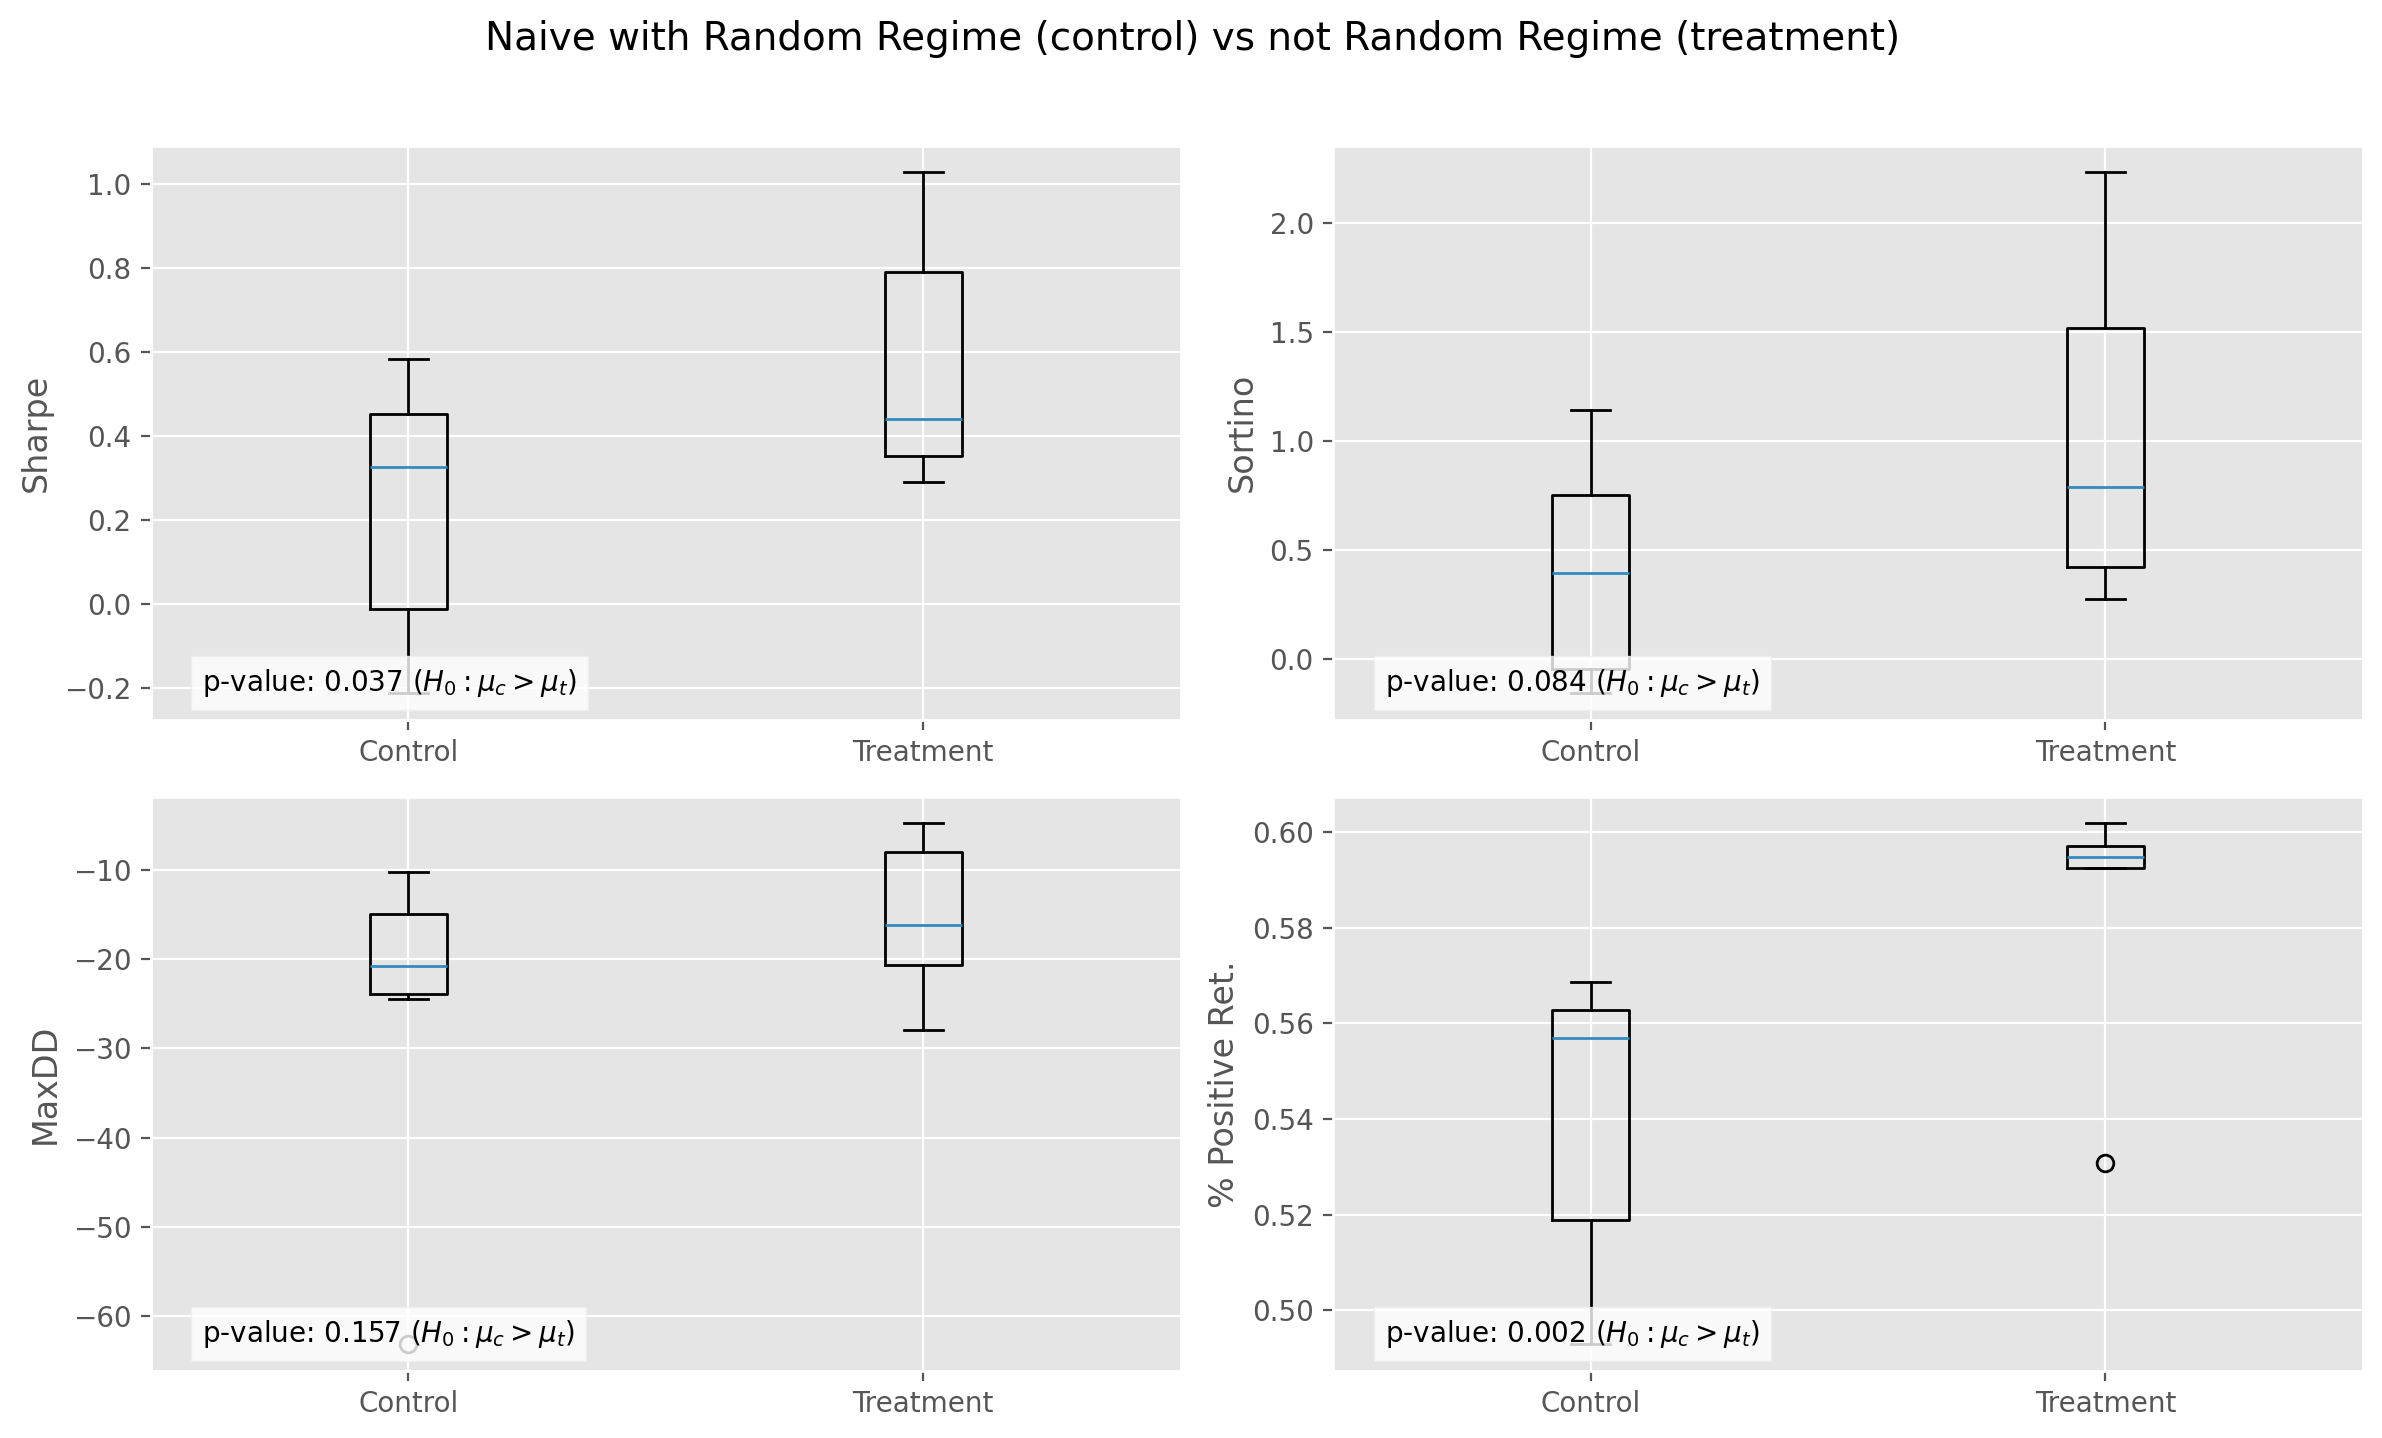

In [34]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Naive with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

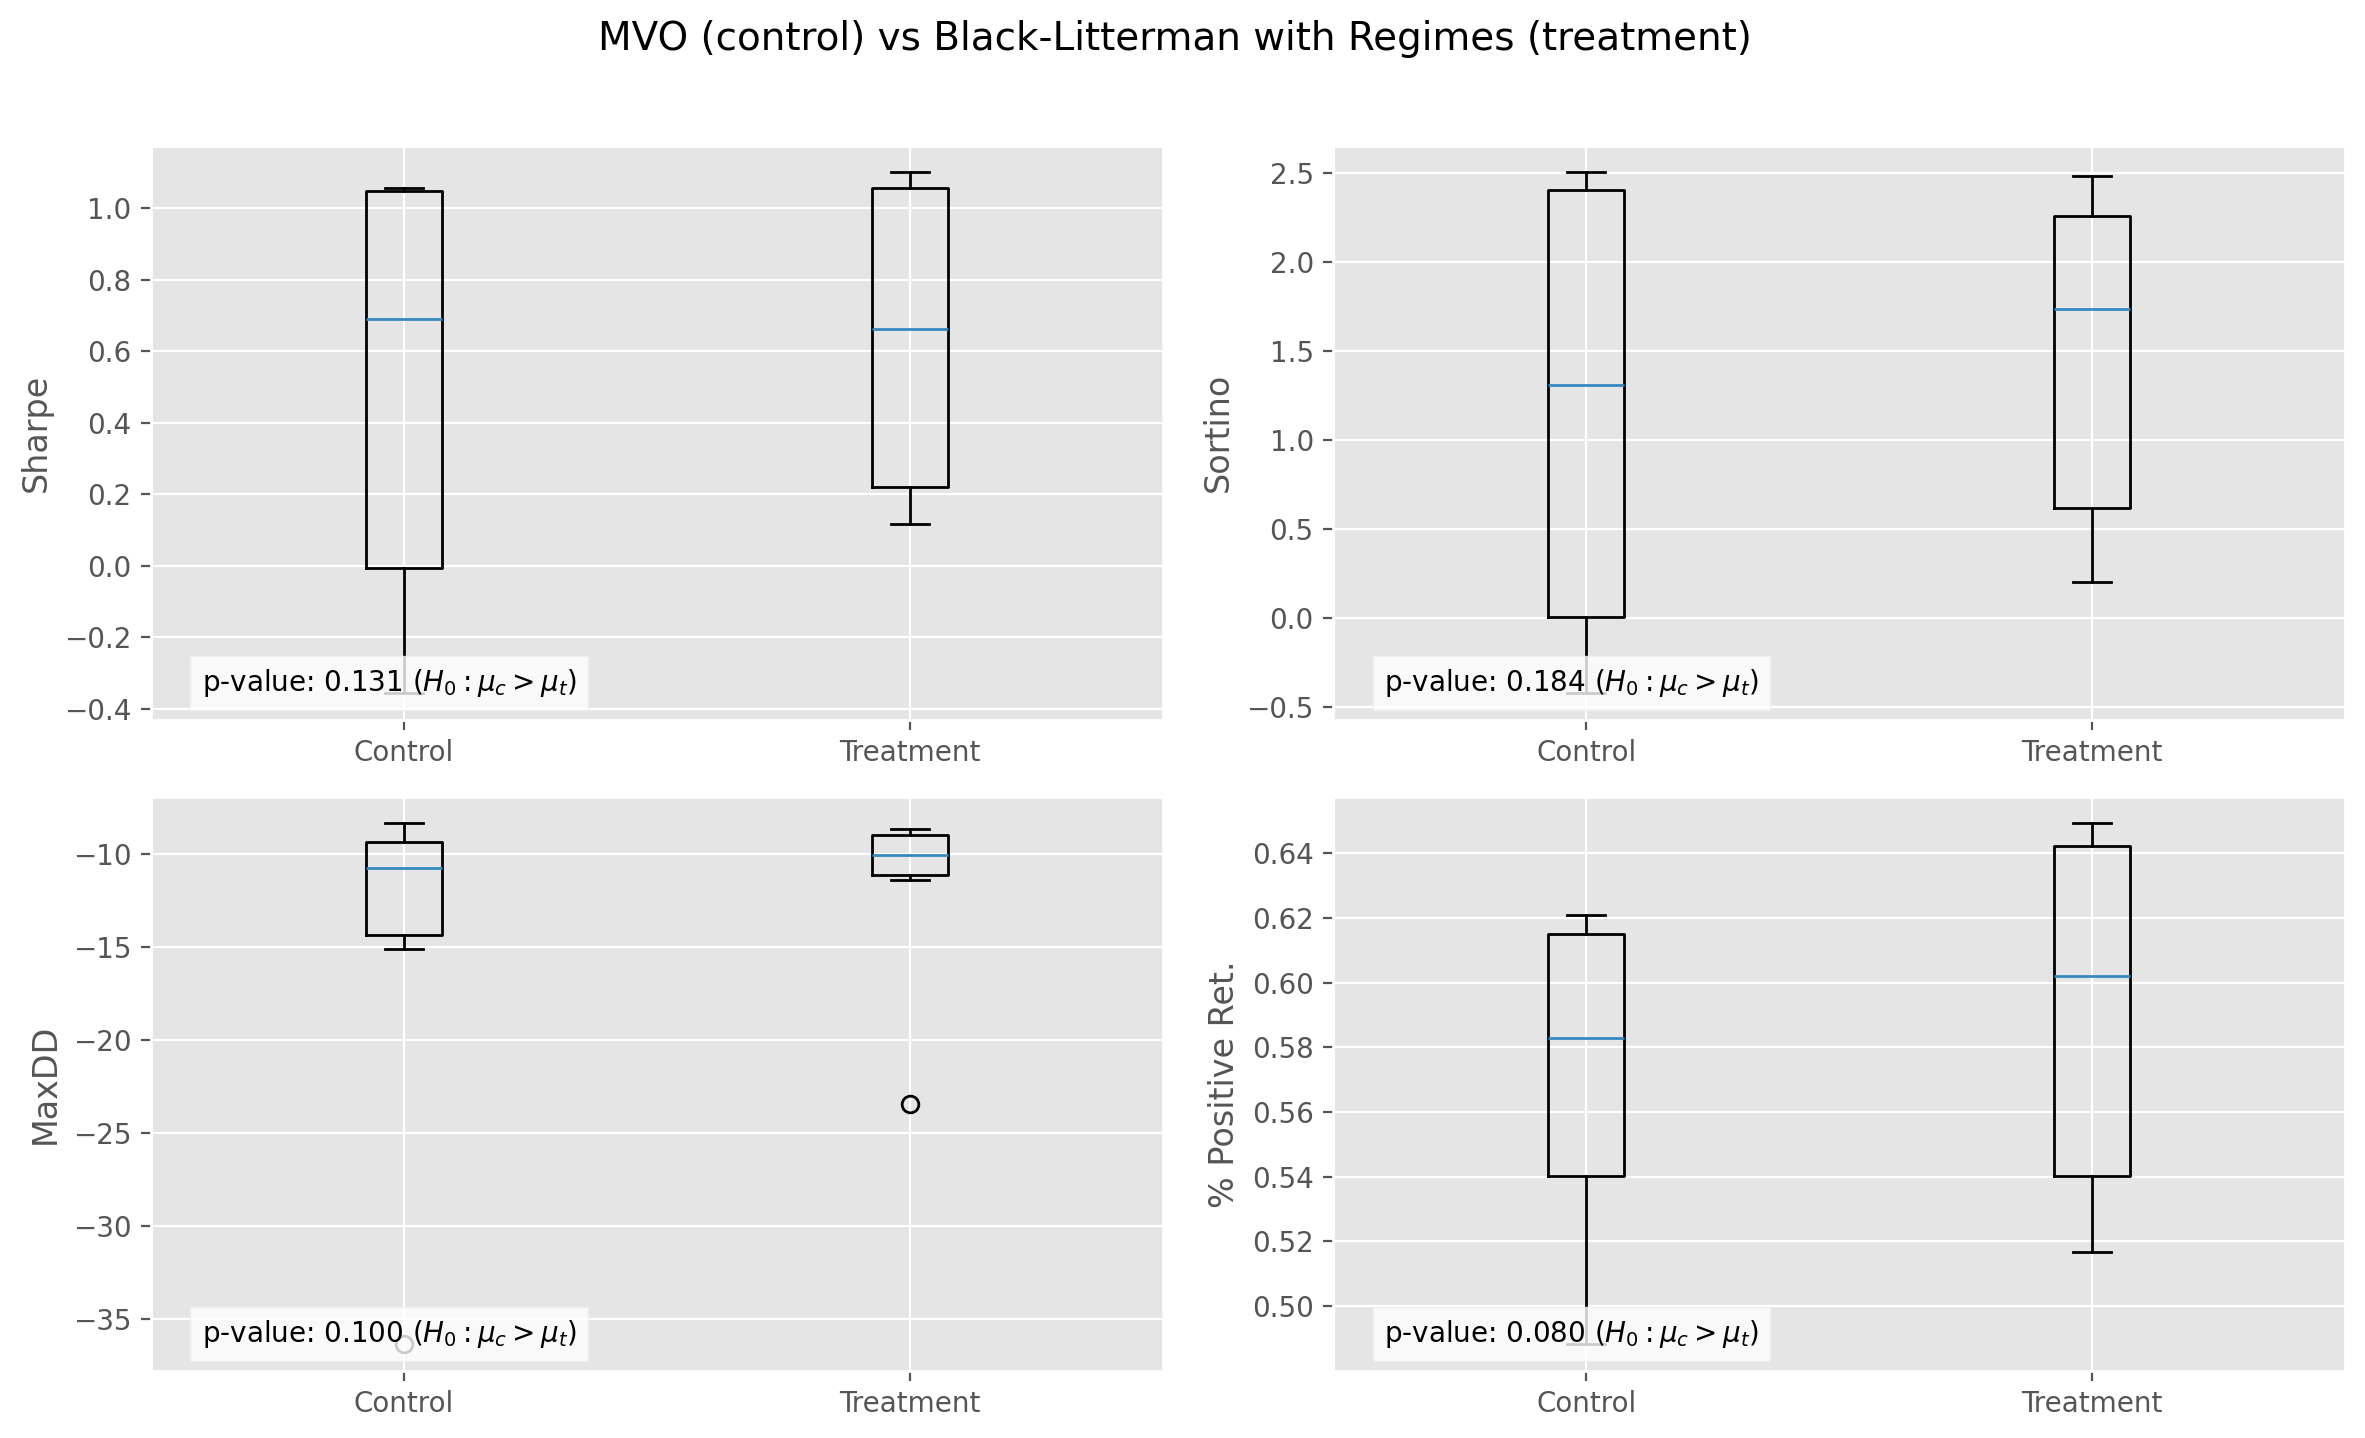

In [35]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["mvo_lns_2", "mvo_lo_2", "mvo_lns_3", "mvo_lo_3", "mvo_lns_4", "mvo_lo_4"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('MVO (control) vs Black-Litterman with Regimes (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

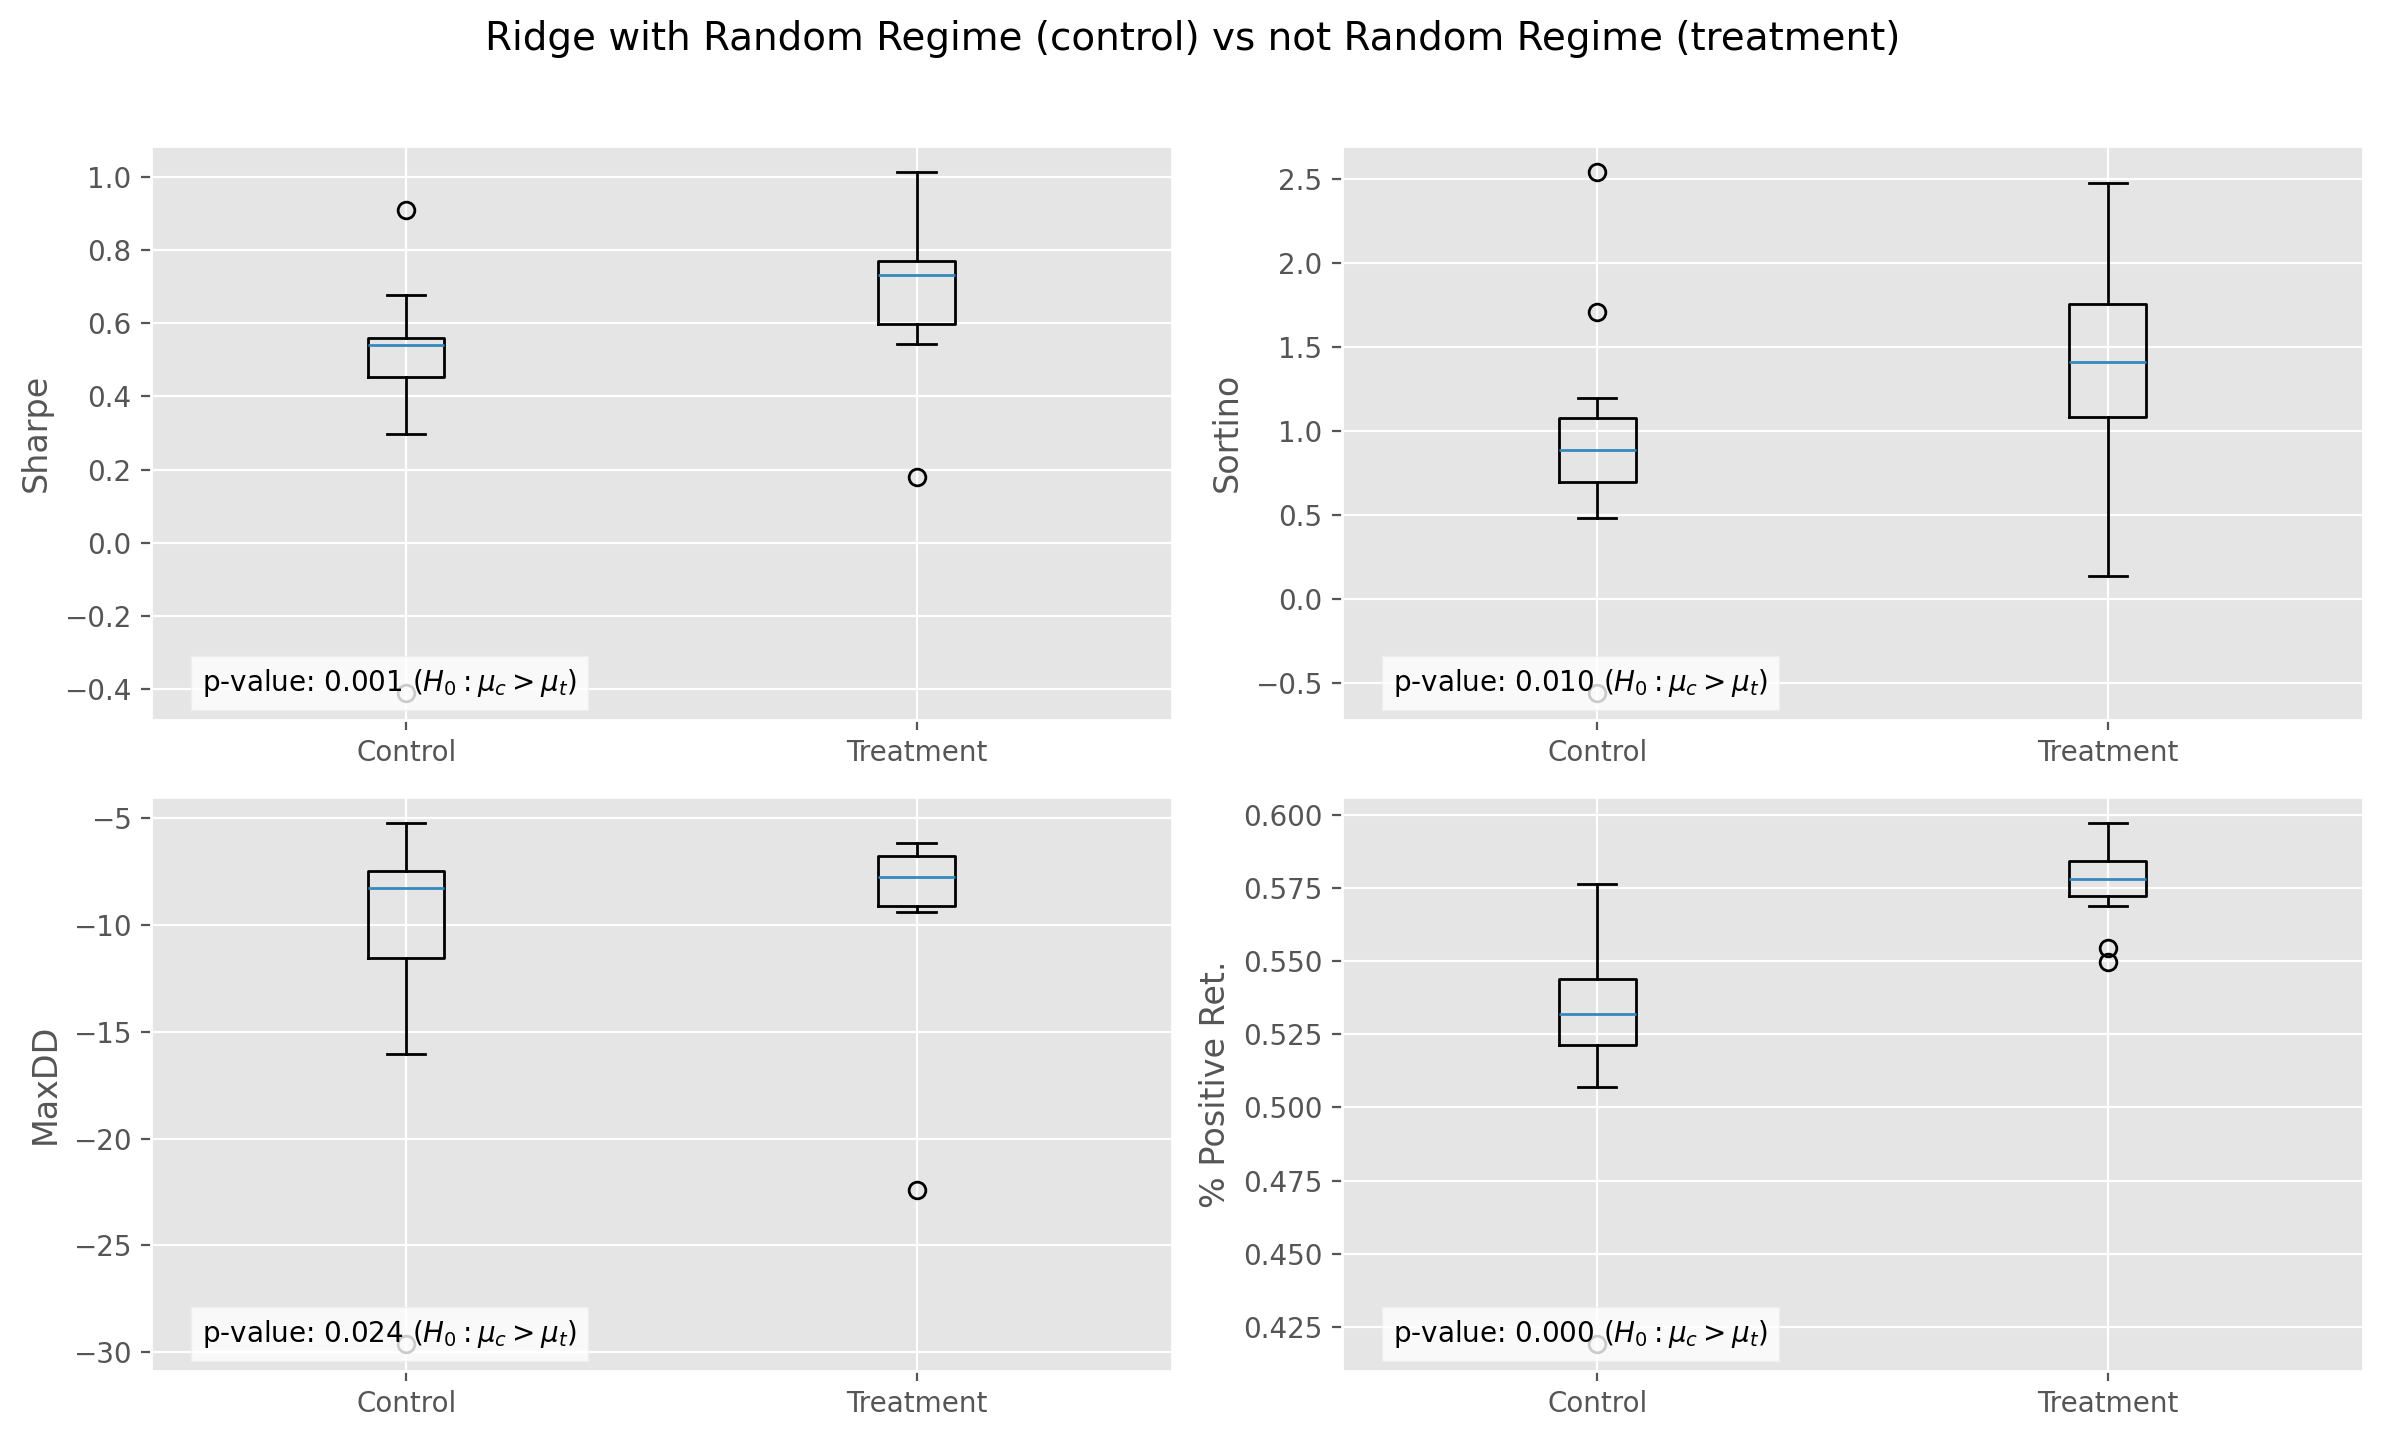

In [36]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = [
    "linear-ridge_lo_2_rand", "linear-ridge_lo_3_rand", "linear-ridge_lo_4_rand", 
    "linear-ridge_lns_3_rand", "linear-ridge_lns_2_rand",  "linear-ridge_lns_4_rand", 
    "linear-ridge_los_3_rand", "linear-ridge_los_2_rand",  "linear-ridge_los_4_rand", 
    "linear-ridge_mx_3_rand", "linear-ridge_mx_2_rand",  "linear-ridge_mx_4_rand", 
]
treatment = [
    "linear-ridge_lo_2", "linear-ridge_lo_3", "linear-ridge_lo_4", 
    "linear-ridge_lns_3", "linear-ridge_lns_2",  "linear-ridge_lns_4", 
    "linear-ridge_los_3", "linear-ridge_los_2",  "linear-ridge_los_4", 
    "linear-ridge_mx_3", "linear-ridge_mx_2",  "linear-ridge_mx_4", 
]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Ridge with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()